# Training Data Cleaning & Exploration

**Overview of Implementation**
1. <a href="#section1">Data Cleaning</a>
2. <a href="#section2">Data Imputation</a>
3. <a href="#section3">CART</a>
4. <a href="#section4">Results</a>

In [1]:
# import libraries
library(data.table)
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


## <a id='section1'>1. Data Cleaning</a>
import data & explore statistics

In [2]:
# Import train data using data.table fread function
wind.dt <- fread("../data/train_data.csv", stringsAsFactors = T) 

cat("Number of NA values: ", sum(is.na(wind.dt)))
summary(wind.dt)

Number of NA values:  20579

   tracking_id                   datetime     wind_speed(m/s)  
 WM_1    :    1   2018-10-28 20:53:20:    1   Min.   :-496.21  
 WM_10   :    1   2018-10-28 21:03:20:    1   1st Qu.:  20.88  
 WM_1000 :    1   2018-10-28 21:33:20:    1   Median :  93.30  
 WM_10000:    1   2018-10-28 21:43:20:    1   Mean   :  69.04  
 WM_10001:    1   2018-10-28 21:53:20:    1   3rd Qu.:  95.27  
 WM_10002:    1   2018-10-28 22:03:20:    1   Max.   : 601.46  
 (Other) :28194   (Other)            :28194   NA's   :273      
 atmospheric_temperature(Â°C) shaft_temperature(Â°C) blades_angle(Â°)   
 Min.   :-99.000              Min.   :-99.00         Min.   :-146.2595  
 1st Qu.:  7.949              1st Qu.: 41.63         1st Qu.:  -1.1977  
 Median : 16.102              Median : 43.69         Median :  -0.4956  
 Mean   :  0.384              Mean   : 40.09         Mean   :  -9.6540  
 3rd Qu.: 23.687              3rd Qu.: 45.67         3rd Qu.:   5.4950  
 Max.   : 80.217              Max.   :169.82      

In [3]:
# get rid of brackets and units in columns
remove_brackets <- function(x) {  
  gsub("\\(.*?\\)", "", x)
  }
colnames(wind.dt) <- sapply(colnames(wind.dt), remove_brackets)
colnames(wind.dt)

[1] "tracking_id"               "datetime"                 
 [3] "wind_speed"                "atmospheric_temperature"  
 [5] "shaft_temperature"         "blades_angle"             
 [7] "gearbox_temperature"       "engine_temperature"       
 [9] "motor_torque"              "generator_temperature"    
[11] "atmospheric_pressure"      "area_temperature"         
[13] "windmill_body_temperature" "wind_direction"           
[15] "resistance"                "rotor_torque"             
[17] "turbine_status"            "cloud_level"              
[19] "blade_length"              "blade_breadth"            
[21] "windmill_height"           "windmill_generated_power"

In [4]:
# Datetime column is in object format. It should be converted into datetime format

get_year <- function(x) {  
  as.POSIXlt(x,format="%Y-%m-%d %H:%M:%S")$year + 1900 # based on 1990
}
get_month <- function(x){
  as.POSIXlt(x,format="%Y-%m-%d %H:%M:%S")$mon + 1 # 0 index
}
get_mday <- function(x){
  as.POSIXlt(x,format="%Y-%m-%d %H:%M:%S")$mday
}
get_wday <- function(x){
  # The wday component of a POSIXlt object is the numeric weekday (0-6 starting on Sunday).
  as.POSIXlt(x,format="%Y-%m-%d %H:%M:%S")$wday
}
get_hour <- function(x){
  as.POSIXlt(x,format="%Y-%m-%d %H:%M:%S")$hour
}
get_min <- function(x){
  as.POSIXlt(x,format="%Y-%m-%d %H:%M:%S")$min
}
get_sec <- function(x){
  as.POSIXlt(x,format="%Y-%m-%d %H:%M:%S")$sec
}

wind.dt$year <- unlist(lapply(wind.dt$datetime, get_year))
wind.dt$month <- unlist(lapply(wind.dt$datetime, get_month))
wind.dt$mday <- unlist(lapply(wind.dt$datetime, get_mday))
wind.dt$wday <- unlist(lapply(wind.dt$datetime, get_wday))
wind.dt$hour <- unlist(lapply(wind.dt$datetime, get_hour))
wind.dt$min <- unlist(lapply(wind.dt$datetime, get_min))
wind.dt$sec <- unlist(lapply(wind.dt$datetime, get_sec))

head(wind.dt)

tracking_id,datetime,wind_speed,atmospheric_temperature,shaft_temperature,blades_angle,gearbox_temperature,engine_temperature,motor_torque,generator_temperature,...,blade_breadth,windmill_height,windmill_generated_power,year,month,mday,wday,hour,min,sec
WM_33725,2019-08-04 14:33:20,94.82002,-99.00000,41.72302,-0.9034229,82.41057,42.52302,2563.1245,76.66556,...,0.3140648,24.28169,6.766521,2019,8,4,0,14,33,20
WM_698,2018-11-05 10:13:20,241.83273,27.76478,-99.00000,-99.0000000,44.10492,46.25887,2372.3841,78.12980,...,0.4484944,27.26214,5.966275,2018,11,5,1,10,13,20
WM_39146,2019-09-14 14:03:20,95.48472,NA,41.85547,12.6527635,42.32210,42.87855,1657.1696,67.65447,...,0.3023210,27.36613,2.874342,2019,9,14,6,14,3,20
WM_6757,2018-12-25 15:33:20,238.81942,-99.00000,45.44391,15.1153228,44.75964,47.28210,2888.1341,95.38997,...,0.3671399,24.28777,14.851089,2018,12,25,2,15,33,20
WM_21521,2019-05-04 03:13:20,10.72289,NA,41.98118,1.7156961,-17.61646,43.46985,781.6954,37.42307,...,0.4533737,27.97165,3.519074,2019,5,4,6,3,13,20
WM_17873,2019-03-22 21:03:20,93.76997,30.32623,17.97062,-99.0000000,43.81643,40.81579,2119.3517,72.34513,...,0.3956420,24.67329,4.945780,2019,3,22,5,21,3,20


In [5]:
wind.dt$year = as.factor(wind.dt$year)
wind.dt$month = as.factor(wind.dt$month)
wind.dt$mday = as.factor(wind.dt$mday)
wind.dt$wday = as.factor(wind.dt$wday)

In [6]:
# drop column tracking_id and datatime
wind.dt[,tracking_id:=NULL]
wind.dt[,datetime:=NULL]
wind.dt[,sec:=NULL]
wind.dt[,min:=NULL]
colnames(wind.dt)
ncol(wind.dt)

[1] "wind_speed"                "atmospheric_temperature"  
 [3] "shaft_temperature"         "blades_angle"             
 [5] "gearbox_temperature"       "engine_temperature"       
 [7] "motor_torque"              "generator_temperature"    
 [9] "atmospheric_pressure"      "area_temperature"         
[11] "windmill_body_temperature" "wind_direction"           
[13] "resistance"                "rotor_torque"             
[15] "turbine_status"            "cloud_level"              
[17] "blade_length"              "blade_breadth"            
[19] "windmill_height"           "windmill_generated_power" 
[21] "year"                      "month"                    
[23] "mday"                      "wday"                     
[25] "hour"

[1] 25

In [7]:
summary(wind.dt)

   wind_speed      atmospheric_temperature shaft_temperature
 Min.   :-496.21   Min.   :-99.000         Min.   :-99.00   
 1st Qu.:  20.88   1st Qu.:  7.949         1st Qu.: 41.63   
 Median :  93.30   Median : 16.102         Median : 43.69   
 Mean   :  69.04   Mean   :  0.384         Mean   : 40.09   
 3rd Qu.:  95.27   3rd Qu.: 23.687         3rd Qu.: 45.67   
 Max.   : 601.46   Max.   : 80.217         Max.   :169.82   
 NA's   :273       NA's   :3450            NA's   :2        
  blades_angle       gearbox_temperature engine_temperature  motor_torque   
 Min.   :-146.2595   Min.   :-244.97     Min.   : 3.167     Min.   : 500.0  
 1st Qu.:  -1.1977   1st Qu.:  40.56     1st Qu.:41.911     1st Qu.: 870.3  
 Median :  -0.4956   Median :  43.22     Median :43.525     Median :2031.8  
 Mean   :  -9.6540   Mean   :  41.03     Mean   :42.614     Mean   :1710.8  
 3rd Qu.:   5.4950   3rd Qu.:  45.88     3rd Qu.:45.174     3rd Qu.:2462.6  
 Max.   : 165.9321   Max.   : 999.00     Max.   :5

In [8]:
#sample split into train and test set
library(caTools)
set.seed(2021)
train <- sample.split(Y=wind.dt$windmill_generated_power, SplitRatio=0.7)
trainset<- subset(wind.dt, train==T)
testset<- subset(wind.dt, train==F)
paste("number of rows of trainset: ",nrow(trainset))
paste("proportion of trainset: ", nrow(trainset)/nrow(wind.dt))
paste("number of rows of testset: ",nrow(testset))
paste("proportion of testset: ", nrow(testset)/nrow(wind.dt))

[1] "number of rows of trainset:  19740"

[1] "proportion of trainset:  0.7"

[1] "number of rows of testset:  8460"

[1] "proportion of testset:  0.3"

## <a id='section2'>2. Data Imputation</a>

Warning message:
"package 'VIM' was built under R version 3.6.3"Loading required package: colorspace
Loading required package: grid
VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.

Suggestions and bug-reports can be submitted at: https://github.com/alexkowa/VIM/issues

Attaching package: 'VIM'

The following object is masked from 'package:datasets':

    sleep



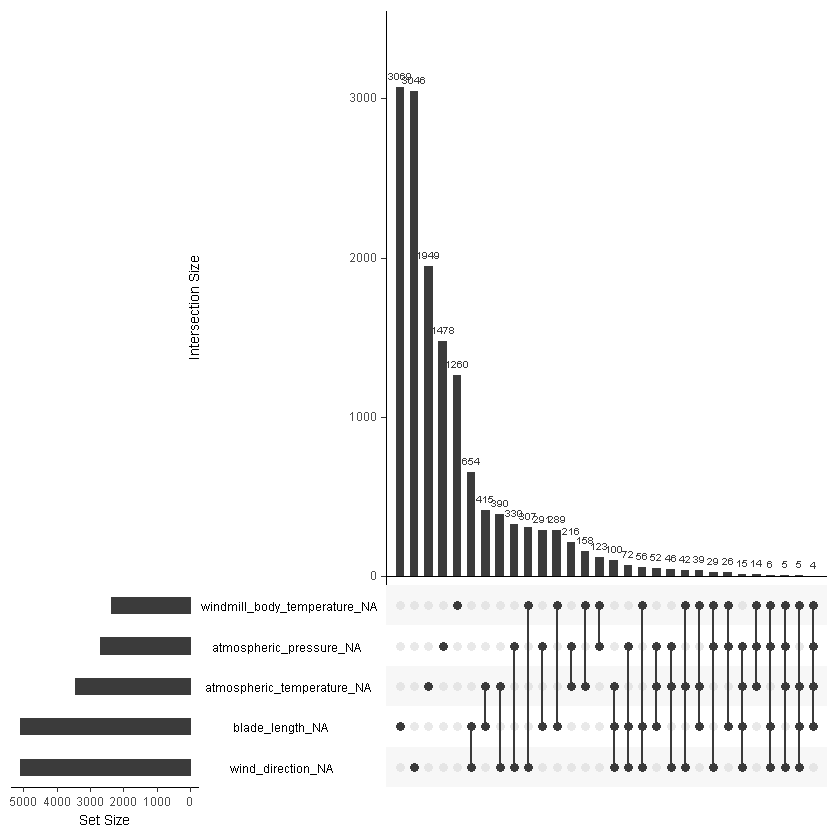

In [9]:
# NA Analysis and Handling
# install.packages("naniar")
library(naniar)
# install.packages("VIM")
library(VIM)

gg_miss_upset(wind.dt) # interesting overview of NA


Warning message in plot.aggr(res, ...):
"not enough vertical space to display frequencies (too many combinations)"


 Variables sorted by number of missings: 
                  Variable        Count
            wind_direction 1.809574e-01
              blade_length 1.806028e-01
   atmospheric_temperature 1.223404e-01
      atmospheric_pressure 9.599291e-02
 windmill_body_temperature 8.379433e-02
              rotor_torque 2.028369e-02
           windmill_height 1.925532e-02
                wind_speed 9.680851e-03
              blades_angle 7.659574e-03
  windmill_generated_power 7.340426e-03
              motor_torque 8.510638e-04
        engine_temperature 4.255319e-04
     generator_temperature 4.255319e-04
         shaft_temperature 7.092199e-05
       gearbox_temperature 3.546099e-05
                resistance 3.546099e-05
          area_temperature 0.000000e+00
            turbine_status 0.000000e+00
               cloud_level 0.000000e+00
             blade_breadth 0.000000e+00
                      year 0.000000e+00
                     month 0.000000e+00
                      mday 0.000000e+

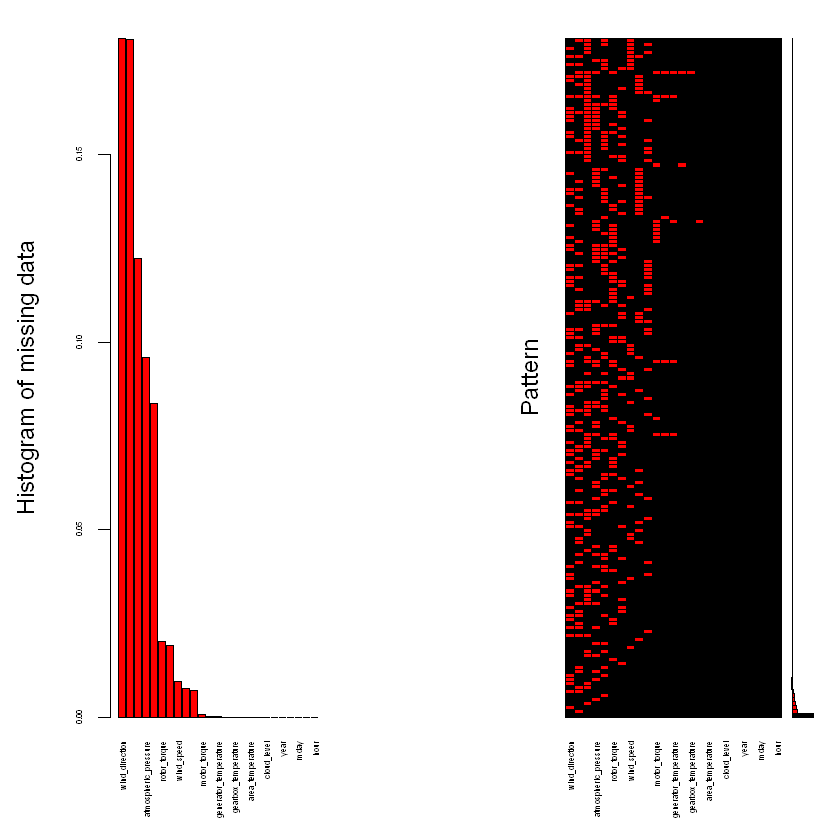

In [10]:
# Missing Values Pattern
aggr_plot <- aggr(wind.dt, col=c('black','red'), 
                  numbers=TRUE, sortVars=TRUE, labels=names(data), 
                  cex.axis=0.4, gap=10, ylab=c("Histogram of missing data","Pattern"))

- **missing columns**: wind_speed  atmospheric_temperature  shaft_temperature  blades_angle  gearbox_temperature  engine_temperature  motor_torque  generator_temperature  atmospheric_pressure  area_temperature  windmill_body_temperature  wind_direction  resistance  rotor_torque  blade_length  windmill_height, turbine_status, cloud_level, windmill_generated_power
- **most number of NA values** come from wind-direction and blade_length
- **most instances of NA values** are unrelated to each other
- **most related pair of NA values** belong to blade_length and wind_direction

In [11]:
# Data imputation with MICE stochastic regression imputation
library(mice)

trainset[trainset == ""] <- NA # account for "" as NA
testset[testset == ""] <- NA

data_imputation = function(data)
{
  # Imputing Numeric missing data using MICE stochastic regression imputation
  imp = mice(data[,c(1:14,17,19:20)], method = "norm.nob", m = 5, maxit = 5)
  data1 = complete(imp,2)
    
    # Filling missing values in categorical variables using KNN imputer
  imp2 = kNN(data[,c(15,16)])
  data2 = imp2[,c(1,2)]
  
  # Concatenating all the imputed features
  data1 = cbind(data[,c(18,21:25)],data1, data2)
  
  return(data1)
}

trainset.imputation <- data_imputation(trainset)
testset.imputation <- data_imputation(testset)

Warning message:
"package 'mice' was built under R version 3.6.3"
Attaching package: 'mice'

The following object is masked from 'package:stats':

    filter

The following objects are masked from 'package:base':

    cbind, rbind




 iter imp variable
  1   1  wind_speed  atmospheric_temperature  blades_angle  engine_temperature  motor_torque  generator_temperature  atmospheric_pressure  windmill_body_temperature  wind_direction  resistance  rotor_torque  blade_length  windmill_height  windmill_generated_power
  1   2  wind_speed  atmospheric_temperature  blades_angle  engine_temperature  motor_torque  generator_temperature  atmospheric_pressure  windmill_body_temperature  wind_direction  resistance  rotor_torque  blade_length  windmill_height  windmill_generated_power
  1   3  wind_speed  atmospheric_temperature  blades_angle  engine_temperature  motor_torque  generator_temperature  atmospheric_pressure  windmill_body_temperature  wind_direction  resistance  rotor_torque  blade_length  windmill_height  windmill_generated_power
  1   4  wind_speed  atmospheric_temperature  blades_angle  engine_temperature  motor_torque  generator_temperature  atmospheric_pressure  windmill_body_temperature  wind_direction  resist

In [12]:
#check NAs
sum(is.na(trainset)) 
sum(is.na(trainset.imputation))
sum(is.na(testset))
sum(is.na(testset.imputation))

[1] 15912

[1] 0

[1] 6702

[1] 0

In [13]:
trainset.imputation$cloud_level <- droplevels(trainset.imputation$cloud_level) # removes unused "" level
trainset$cloud_level <- droplevels(trainset$cloud_level) # removes unused "" level
testset.imputation$cloud_level <- droplevels(testset.imputation$cloud_level) # removes unused "" level
testset$cloud_level <- droplevels(testset$cloud_level) # removes unused "" level

### We have 2 training datasets, one with data imputation to handle NAs and one without handling of NAs. We will put both through CART and against a testset that has imputation and one that has NAs

## <a id='section3'>3. CART</a>

In [14]:
library(rpart)
#install.packages("rpart.plot")
library(rpart.plot)

In [15]:
#cart for trainset with na
cart.na<- rpart(windmill_generated_power~., data=trainset, method='anova',control=rpart.control(minsplit=2,cp=0))

In [16]:
#print tree
printcp(cart.na)


Regression tree:
rpart(formula = windmill_generated_power ~ ., data = trainset, 
    method = "anova", control = rpart.control(minsplit = 2, cp = 0))

Variables actually used in tree construction:
 [1] area_temperature          atmospheric_pressure     
 [3] atmospheric_temperature   blade_breadth            
 [5] blade_length              blades_angle             
 [7] cloud_level               engine_temperature       
 [9] gearbox_temperature       generator_temperature    
[11] hour                      mday                     
[13] month                     motor_torque             
[15] resistance                rotor_torque             
[17] shaft_temperature         turbine_status           
[19] wday                      wind_direction           
[21] wind_speed                windmill_body_temperature
[23] windmill_height           year                     

Root node error: 143089/19583 = 7.3068

n=19583 (157 observations deleted due to missingness)

              CP nspli

In [17]:
#determine cp to prune at
CVerror.cap<-cart.na$cptable[which.min(cart.na$cptable[,"xerror"]),"xerror"]+ cart.na$cptable[which.min(cart.na$cptable[,"xerror"]),"xstd"]

In [18]:
i<-1;j<-4
while (cart.na$cptable[i,j]>CVerror.cap){
    i<-i+1
}

cp.opt = ifelse(i>1,sqrt(cart.na$cptable[i,1]*cart.na$cptable[i-1,1]),1)
i
cp.opt

[1] 74

[1] 0.0004412327

In [19]:
#prune
cart.na.prune<-prune(cart.na,cp=cp.opt)
printcp(cart.na.prune, digits=3)


Regression tree:
rpart(formula = windmill_generated_power ~ ., data = trainset, 
    method = "anova", control = rpart.control(minsplit = 2, cp = 0))

Variables actually used in tree construction:
 [1] atmospheric_pressure    atmospheric_temperature blade_breadth          
 [4] blades_angle            engine_temperature      gearbox_temperature    
 [7] generator_temperature   hour                    mday                   
[10] month                   motor_torque            resistance             
[13] wind_speed             

Root node error: 143089/19583 = 7.31

n=19583 (157 observations deleted due to missingness)

         CP nsplit rel error xerror    xstd
1  0.437820      0    1.0000 1.0001 0.01111
2  0.108514      1    0.5622 0.5626 0.00772
3  0.053623      2    0.4537 0.4545 0.00761
4  0.048350      3    0.4000 0.4014 0.00690
5  0.033814      4    0.3517 0.3537 0.00652
6  0.029007      5    0.3179 0.3204 0.00624
7  0.023332      8    0.2309 0.2340 0.00576
8  0.014128      9 

In [20]:
#repeat for trainset with imputation
cart.imputed<- rpart(windmill_generated_power~., data=trainset.imputation, method='anova',control=rpart.control(minsplit=2,cp=0))

In [21]:
#print tree
printcp(cart.imputed)


Regression tree:
rpart(formula = windmill_generated_power ~ ., data = trainset.imputation, 
    method = "anova", control = rpart.control(minsplit = 2, cp = 0))

Variables actually used in tree construction:
 [1] area_temperature          atmospheric_pressure     
 [3] atmospheric_temperature   blade_breadth            
 [5] blade_length              blades_angle             
 [7] cloud_level               engine_temperature       
 [9] gearbox_temperature       generator_temperature    
[11] hour                      mday                     
[13] month                     motor_torque             
[15] resistance                rotor_torque             
[17] shaft_temperature         turbine_status           
[19] wday                      wind_direction           
[21] wind_speed                windmill_body_temperature
[23] windmill_height           year                     

Root node error: 144314/19740 = 7.3107

n= 19740 

              CP nsplit  rel error   xerror      xstd
1

In [22]:
#determine cp to prune at
CVerror.cap<-cart.imputed$cptable[which.min(cart.imputed$cptable[,"xerror"]),"xerror"]+ cart.imputed$cptable[which.min(cart.imputed$cptable[,"xerror"]),"xstd"]

In [23]:
i<-1;j<-4
while (cart.imputed$cptable[i,j]>CVerror.cap){
    i<-i+1
}

cp.opt = ifelse(i>1,sqrt(cart.imputed$cptable[i,1]*cart.imputed$cptable[i-1,1]),1)
i
cp.opt

[1] 64

[1] 0.0005038653

In [24]:
#prune
cart.imputed.prune<-prune(cart.imputed,cp=cp.opt)
printcp(cart.imputed.prune, digits=3)


Regression tree:
rpart(formula = windmill_generated_power ~ ., data = trainset.imputation, 
    method = "anova", control = rpart.control(minsplit = 2, cp = 0))

Variables actually used in tree construction:
 [1] atmospheric_pressure  blade_breadth         blade_length         
 [4] blades_angle          engine_temperature    gearbox_temperature  
 [7] generator_temperature mday                  month                
[10] motor_torque          resistance           

Root node error: 144314/19740 = 7.31

n= 19740 

         CP nsplit rel error xerror    xstd
1  0.435230      0    1.0000 1.0001 0.01105
2  0.107496      1    0.5648 0.5657 0.00765
3  0.050006      2    0.4573 0.4568 0.00753
4  0.047837      3    0.4073 0.4140 0.00677
5  0.037155      4    0.3594 0.3617 0.00620
6  0.026692      5    0.3223 0.3261 0.00580
7  0.023695      6    0.2956 0.2954 0.00555
8  0.019556      7    0.2719 0.2757 0.00578
9  0.014058      8    0.2523 0.2560 0.00571
10 0.010365      9    0.2383 0.2466 0.0

In [25]:
#trainset with NAs variable importance
cart.na.prune$variable.importance
scaledVarImpt <- round(100*cart.na.prune$variable.importance/sum(cart.na.prune$variable.importance))
scaledVarImpt[scaledVarImpt > 3]  # Print all var impt > cutoff

motor_torque     generator_temperature                resistance 
             92641.433850              71914.787855              64976.858942 
             rotor_torque              blades_angle      atmospheric_pressure 
             38323.979959              35085.741196              14434.111767 
               wind_speed        engine_temperature                     month 
             13460.835762              13250.892370               8849.062341 
                     mday             blade_breadth   atmospheric_temperature 
              2410.061250               2404.257357               1754.330604 
         area_temperature       gearbox_temperature                      hour 
              1724.077307                466.567665                423.979447 
              cloud_level         shaft_temperature                      wday 
               295.052087                141.832842                124.214704 
           turbine_status            wind_direction windmill_body_temperature 
                17.023984                 14.391010                  9.542102

motor_torque generator_temperature            resistance 
                   26                    20                    18 
         rotor_torque          blades_angle  atmospheric_pressure 
                   11                    10                     4 
           wind_speed    engine_temperature 
                    4                     4

In [26]:
#trainset with imputation variable importance
cart.imputed.prune$variable.importance
scaledVarImpt <- round(100*cart.imputed.prune$variable.importance/sum(cart.imputed.prune$variable.importance))
scaledVarImpt[scaledVarImpt > 3]  # Print all var impt > cutoff

motor_torque     generator_temperature                resistance 
              88526.96058               70826.12669               61139.87322 
             rotor_torque              blades_angle                     month 
              44215.69365               37993.00002               14550.76142 
       engine_temperature                wind_speed   atmospheric_temperature 
              13983.38634               12776.50259                5349.15779 
     atmospheric_pressure            wind_direction             blade_breadth 
               4659.68140                2403.24538                2334.74567 
                     mday          area_temperature               cloud_level 
               1845.33547                1140.13369                1102.92428 
      gearbox_temperature                      hour         shaft_temperature 
                696.05355                 523.99824                 221.98565 
                     wday              blade_length windmill_body_temperature 
                132.56110                 122.88981                  92.79464 
           turbine_status           windmill_height                      year 
                 63.49653                  58.37849                  41.01882

motor_torque generator_temperature            resistance 
                   24                    19                    17 
         rotor_torque          blades_angle                 month 
                   12                    10                     4 
   engine_temperature            wind_speed 
                    4                     4

## <a id='section4'>4. Results</a>

In [27]:
library(Metrics)
#prediction using both trainsets on testset with NAs
train.na.predict.na<-predict(cart.na.prune, newdata=testset)
train.imputed.predict.na<-predict(cart.imputed.prune,newdata=testset)
testset.na.actual<-testset$windmill_generated_power
train.na.predict.imputed<-predict(cart.na.prune,newdata=testset.imputation)
train.imputed.predict.imputed<-predict(cart.imputed.prune,newdata=testset.imputation)
testset.imputed.actual<-testset.imputation$windmill_generated_power


Attaching package: 'Metrics'

The following objects are masked from 'package:VIM':

    mape, smape



In [28]:
#form result dataframe
rmse.df<- data.frame(train.na.predict.na,train.imputed.predict.na,testset.na.actual,train.na.predict.imputed,train.imputed.predict.imputed,testset.imputed.actual)
nrow(rmse.df) #8460

[1] 8460

In [29]:
head(rmse.df)

train.na.predict.na,train.imputed.predict.na,testset.na.actual,train.na.predict.imputed,train.imputed.predict.imputed,testset.imputed.actual
6.319536,6.328044,5.966275,6.319536,6.328044,5.966275
3.311535,3.658953,2.874342,3.311535,3.658953,2.874342
4.911733,5.030405,4.945780,4.911733,5.030405,4.945780
8.754469,8.178129,8.739166,8.754469,8.178129,8.739166
1.674652,1.691930,1.948810,1.674652,1.691930,1.948810
4.911733,5.266693,5.229220,4.911733,5.266693,5.229220


In [30]:
#check NAs in testset target variable
sum(is.na(testset.na.actual)) #50
sum(is.na(testset.imputed.actual)) #0

[1] 50

[1] 0

In [31]:
#remove rows with NA in target variable
rmse2.df<-rmse.df[!(is.na(rmse.df$testset.na.actual)),]
nrow(rmse2.df) #8410
sum(is.na(rmse2.df$testset.na.actual)) #0

[1] 8410

[1] 0

In [32]:
#calculate rmse
rmse.train.na.test.na <- rmse(rmse2.df$train.na.predict.na,rmse2.df$testset.na.actual)
rmse.train.imputed.test.na <- rmse(rmse2.df$train.imputed.predict.na,rmse2.df$testset.na.actual)
rmse.train.na.test.imputed <- rmse(rmse2.df$train.na.predict.imputed,rmse2.df$testset.imputed.actual)
rmse.train.imputed.test.imputed <- rmse(rmse2.df$train.imputed.predict.imputed,rmse2.df$testset.imputed.actual)

In [33]:
paste("rmse of unimputed trainset with unimputed testset: ",rmse.train.na.test.na)
paste("rmse of imputed trainset with unimputed testset: ",rmse.train.imputed.test.na)
paste("rmse of unimputed trainset with imputed testset: ",rmse.train.na.test.imputed)
paste("rmse of imputed trainset with imputed testset: ",rmse.train.imputed.test.imputed)

[1] "rmse of unimputed trainset with unimputed testset:  0.728750027903112"

[1] "rmse of imputed trainset with unimputed testset:  0.780166034652001"

[1] "rmse of unimputed trainset with imputed testset:  0.793216876911028"

[1] "rmse of imputed trainset with imputed testset:  0.781643986346208"

In [ ]:
#things to explore:
#remove mday and wday
#remove imputation of target variable of trainset
#change imputation?
#analyse variable importance and ideal variable values